In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/kairess/semantic-segmentation-pytorch.git

Cloning into 'semantic-segmentation-pytorch'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 19 (delta 0), reused 19 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [3]:
%cd /content/drive/MyDrive/new/

/content/drive/MyDrive/new


In [4]:
ls

bg.jpeg  cartoonGAN/               train/     Untitled0.ipynb
bg.jpg   CartoonGAN_project-main/  train.zip  wbg.jpg


In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torchvision import transforms, models
import cv2

In [6]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


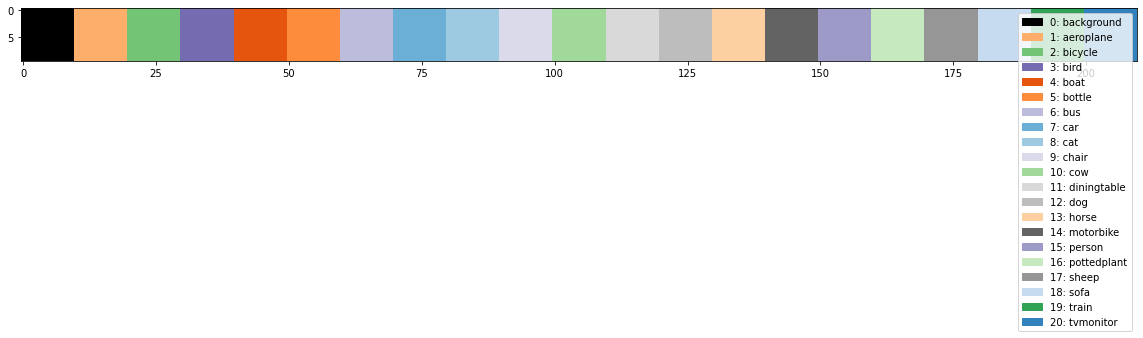

In [7]:
labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

cmap = plt.cm.get_cmap('tab20c')
colors = (cmap(np.arange(cmap.N)) * 255).astype(np.int)[:, :3].tolist()
np.random.seed(2020)
np.random.shuffle(colors)
colors.insert(0, [0, 0, 0]) # background color must be black
colors = np.array(colors, dtype=np.uint8)

palette_map = np.empty((10, 0, 3), dtype=np.uint8)
legend = []

for i in range(21):
    legend.append(mpatches.Patch(color=np.array(colors[i]) / 255., label='%d: %s' % (i, labels[i])))
    c = np.full((10, 10, 3), colors[i], dtype=np.uint8)
    palette_map = np.concatenate([palette_map, c], axis=1)

plt.figure(figsize=(20, 2))
plt.legend(handles=legend)
plt.imshow(palette_map)

In [8]:
def segment(net, img):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    output = model(input_batch)['out'][0] # (21, height, width)

    output_predictions = output.argmax(0).byte().cpu().numpy() # (height, width) 

    r = Image.fromarray(output_predictions).resize((img.shape[1], img.shape[0]))
    r.putpalette(colors)

    return r, output_predictions

In [11]:
# # 압축파일 해제
# from zipfile import ZipFile

# with ZipFile('/content/drive/MyDrive/new/train.zip') as z: 
#     z.extractall()

In [12]:
# # 구글 드라이버로 이동된 dataset 확인
# !ls /content/

drive  sample_data  semantic-segmentation-pytorch


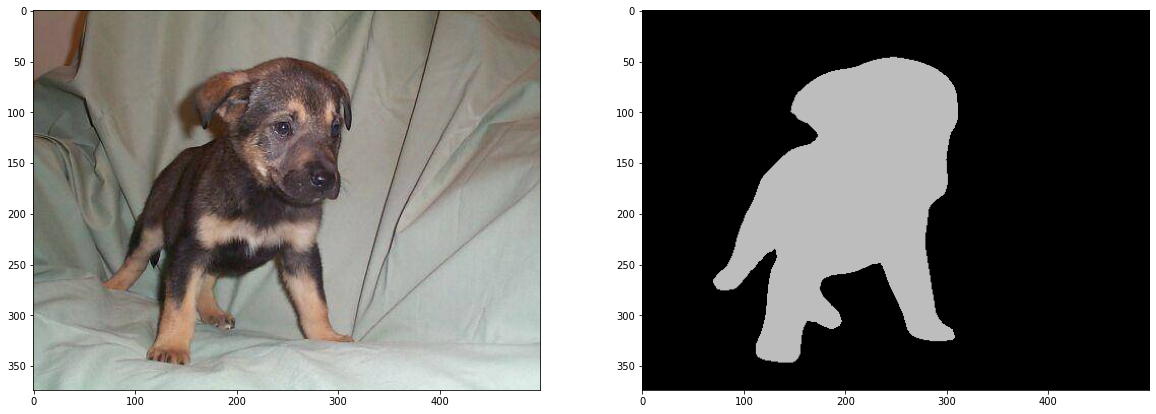

In [9]:
img = np.array(Image.open('dog.5087.jpg'))

fg_h, fg_w, _ = img.shape

segment_map, pred = segment(model, img)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(segment_map)

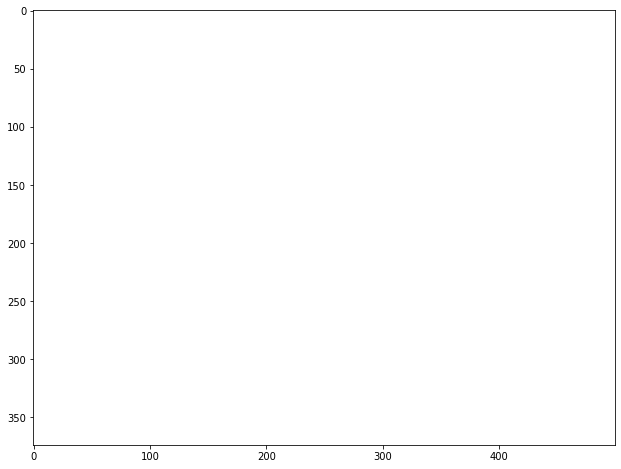

In [10]:
background = np.array(Image.open('/content/drive/MyDrive/new/wbg.jpg'))

bg_h, bg_w, _ = background.shape

# fit to fg width
background = cv2.resize(background, dsize=(fg_w, int(fg_w * bg_h / bg_w)))

bg_h, bg_w, _ = background.shape

margin = (bg_h - fg_h) // 2

if margin > 0:
    background = background[margin:-margin, :, :]
else:
    background = cv2.copyMakeBorder(background, top=abs(margin), bottom=abs(margin), left=0, right=0, borderType=cv2.BORDER_REPLICATE)

# final resize
background = cv2.resize(background, dsize=(fg_w, fg_h))

plt.figure(figsize=(12, 8))
plt.imshow(background)

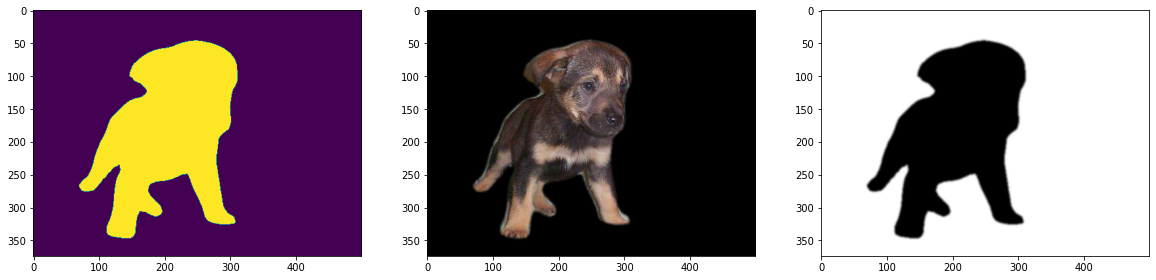

In [11]:
#누끼딸 객체 지정하는 부분
mask1 = (pred == 12).astype(float) * 255 # 강아지
mask2 = (pred == 8).astype(float) * 255 # 고양이

mask3 = mask1 + mask2
_, alpha = cv2.threshold(mask3, 0, 255, cv2.THRESH_BINARY)

alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)

alpha = alpha / 255. # (height, width)
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) 
# 사진 누끼 딴 부분
foreground = cv2.multiply(alpha, img.astype(float))
#배경에 사진 부분 도려낸 나머지
background = cv2.multiply(1. - alpha, background.astype(float))  

fig,axes = plt.subplots(1,3,figsize=(20,10))
axes[0].imshow(mask3)
axes[1].imshow(foreground.astype(np.uint8))
axes[2].imshow(background.astype(np.uint8))

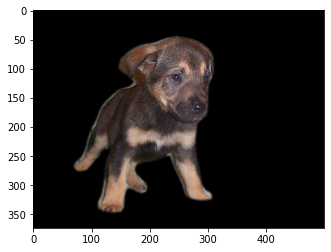

In [14]:
result = foreground.astype(np.uint8)
Image.fromarray(result).save('result.jpg')
plt.imshow(result)

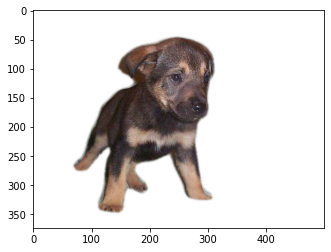

In [15]:
result = cv2.add(foreground,background).astype(np.uint8)
Image.fromarray(result).save('result2.jpg')

plt.imshow(result)